# 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

## Get Helper Function

In [2]:
# importing required libraries 
import tensorflow as tf 
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
!wget https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py

--2022-11-30 14:03:22--  https://raw.githubusercontent.com/SNNJM/Tensorflow_Deep_Learning/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10308 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.07K  --.-KB/s    in 0s      

2022-11-30 14:03:22 (59.3 MB/s) - ‘helper_function.py’ saved [10308/10308]



In [4]:
# Import the helper fn
from helper_function import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get 10% Food Vison data

In [5]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-11-30 14:03:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   217MB/s    in 0.7s    

2022-11-30 14:03:34 (217 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Process data

In [7]:
# Create training and test dir paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32 #Default=32

#Turn data into tensors of numbers
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", #multiclass="categorical"=categorical_crossentropy   binary="binary"=binary_crossentropy
                                                                            batch_size=BATCH_SIZE)

# Note: Test data does not change, only train data change
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical", #multiclass="categorical"=categorical_crossentropy   binary="binary"=binary_crossentropy
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [33]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Create ModelCheckpoint callback

In [10]:
# Set checkpoint path
checkpoint_path = "ten_precent_model_checkpoints_weights/checkpoint.ckpt"

# Create ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True)

## Build transfer learning feature extraction model using the Keras Functional API

Base model: EfficientNetB0

Epochs: 10

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we want to include our own top layer

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2, we'll need to normalize inputs. No need for EfficientNet
# If model is not learning or having issues, enable this line
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggreate the most important information, reduce num of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)


# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)



16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Compile ,Fit and save model's weight using ModelCheckpoint callback

In [13]:
# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# 10 Fit the model & save its weight using ModelCheckpoint callback
initial_epochs=3
history_0 = model_0.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # validate only on 25% of data, so its quicker since test data is larger
                        callbacks=[checkpoint_callback])


Epoch 1/3
24/24 [==============================] - 93s 4s/step - loss: 1.8829 - accuracy: 0.4320 - val_loss: 1.3103 - val_accuracy: 0.7467
Epoch 2/3
24/24 [==============================] - 84s 4s/step - loss: 1.0909 - accuracy: 0.7813 - val_loss: 0.8451 - val_accuracy: 0.8289
Epoch 3/3
24/24 [==============================] - 86s 4s/step - loss: 0.7811 - accuracy: 0.8320 - val_loss: 0.7014 - val_accuracy: 0.8487


In [14]:
# check model performance with full dataset
# history_10_percent_data_ori = model_0.evaluate(test_data)
model_0.evaluate(test_data)

79/79 [==============================] - 160s 2s/step - loss: 0.6996 - accuracy: 0.8452


[0.6996052265167236, 0.8452000021934509]

# 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

## Check what layers are in our base_model(EfficientNetB0) and are they trainable

In [15]:
# What layers are in our base_model(EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_0.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 False
2 global_average_pooling_layer True
3 output_layer True


## unfreeze some of those layers (last 20) ..Make them trainable

In [16]:
# Check How many trainable variable are in our base model?
print(len(model_0.layers[2].trainable_variables))

0


In [17]:
base_model.trainable = True

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:  #every layer except last 20
  layer.trainable =  False

In [18]:
# Check trainable layers --list
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [19]:
# Check for number of trainable variables again
print(len(model_0.trainable_variables))

21


## Recompile & Refit model once trainable layers are confirmed

In [20]:
# Recompile (need to recompile after every changes)
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [21]:
# Fine tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 but with more trainable layers)
history_fine_10_percent= model_0.fit(train_data_10_percent,
                                     epochs=fine_tune_epochs,
                                     validation_data=test_data,
                                     steps_per_epoch=len(train_data_10_percent),
                                     initial_epoch=history_0.epoch[-1], # start from previous last epoch
                                     validation_steps=int(0.25 * len(test_data)))
                                               

Epoch 3/13
24/24 [==============================] - 104s 4s/step - loss: 1.1863 - accuracy: 0.7000 - val_loss: 0.6000 - val_accuracy: 0.8405
Epoch 4/13
24/24 [==============================] - 91s 4s/step - loss: 0.8215 - accuracy: 0.8427 - val_loss: 0.5256 - val_accuracy: 0.8421
Epoch 5/13
24/24 [==============================] - 92s 4s/step - loss: 0.6188 - accuracy: 0.8827 - val_loss: 0.4789 - val_accuracy: 0.8520
Epoch 6/13
24/24 [==============================] - 94s 4s/step - loss: 0.4842 - accuracy: 0.9253 - val_loss: 0.4432 - val_accuracy: 0.8668
Epoch 7/13
24/24 [==============================] - 95s 4s/step - loss: 0.4055 - accuracy: 0.9240 - val_loss: 0.4172 - val_accuracy: 0.8734
Epoch 8/13
24/24 [==============================] - 95s 4s/step - loss: 0.3333 - accuracy: 0.9440 - val_loss: 0.3992 - val_accuracy: 0.8799
Epoch 9/13
24/24 [==============================] - 96s 4s/step - loss: 0.3069 - accuracy: 0.9547 - val_loss: 0.3684 - val_accuracy: 0.8914
Epoch 10/13
24/24 [

## Evaluate the fine tuned data

In [22]:
# Evaluate the fine-tuned model with full dataset
results_last_20_layers_model = model_0.evaluate(test_data)
results_last_20_layers_model

79/79 [==============================] - 158s 2s/step - loss: 0.3677 - accuracy: 0.8844


[0.3676920533180237, 0.8844000101089478]

## Plot loss curve

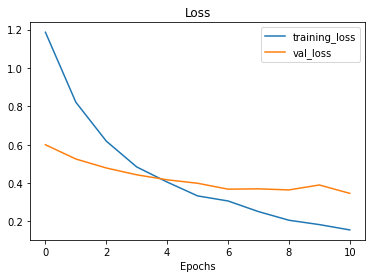

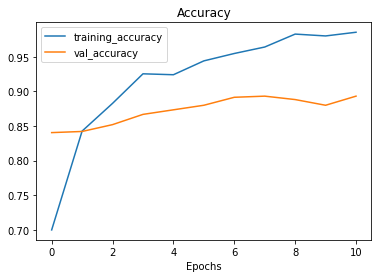

In [23]:
plot_loss_curves(history_fine_10_percent)

# 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [24]:
# Load weight model
model_0.load_weights("ten_precent_model_checkpoints_weights/checkpoint.ckpt")

In [25]:
# Check layers
for i, layer in enumerate(model_0.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 global_average_pooling_layer True
3 output_layer True


In [26]:
# Fine tuning the model (unfreezing all the layer and refreezing everything excpet the last 30 layers)
base_model.trainable = True

# Refreeze every layer except for the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [27]:
# Check (list) layers trainable or not
for num , layer in enumerate(base_model.layers):
  print(num,layer.name, layer.trainable)



0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [28]:
# Re-compiling model for fine tuning 
model_0.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

In [29]:
# Fitting the model for fine tuning 

fine_tune_epochs = initial_epochs + 10
history_fine_tune_model_30 = model_0.fit(train_data_10_percent, 
                                      epochs = fine_tune_epochs ,
                                      steps_per_epoch=len(train_data_10_percent),
                                      validation_data = test_data , 
                                      validation_steps = len(test_data),
                                      initial_epoch =history_0.epoch[-1])



Epoch 3/13
24/24 [==============================] - 235s 10s/step - loss: 1.2331 - accuracy: 0.6653 - val_loss: 0.5909 - val_accuracy: 0.8508
Epoch 4/13
24/24 [==============================] - 217s 9s/step - loss: 0.8339 - accuracy: 0.8333 - val_loss: 0.5270 - val_accuracy: 0.8564
Epoch 5/13
24/24 [==============================] - 217s 9s/step - loss: 0.6469 - accuracy: 0.8653 - val_loss: 0.4838 - val_accuracy: 0.8616
Epoch 6/13
24/24 [==============================] - 218s 9s/step - loss: 0.4971 - accuracy: 0.9187 - val_loss: 0.4491 - val_accuracy: 0.8676
Epoch 7/13
24/24 [==============================] - 208s 9s/step - loss: 0.3917 - accuracy: 0.9400 - val_loss: 0.4268 - val_accuracy: 0.8744
Epoch 8/13
24/24 [==============================] - 208s 9s/step - loss: 0.3309 - accuracy: 0.9467 - val_loss: 0.4132 - val_accuracy: 0.8776
Epoch 9/13
24/24 [==============================] - 209s 9s/step - loss: 0.2879 - accuracy: 0.9613 - val_loss: 0.4023 - val_accuracy: 0.8804
Epoch 10/13


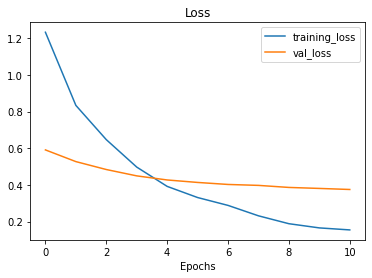

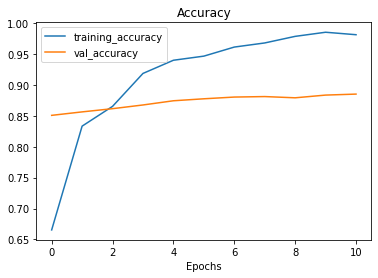

In [30]:
plot_loss_curves(history_fine_tune_model_30)

# 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [37]:
# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [dataset.class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if dataset.class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {dataset.class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')

In [39]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [35]:
test_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

1/1 [==============================] - 0s 91ms/step


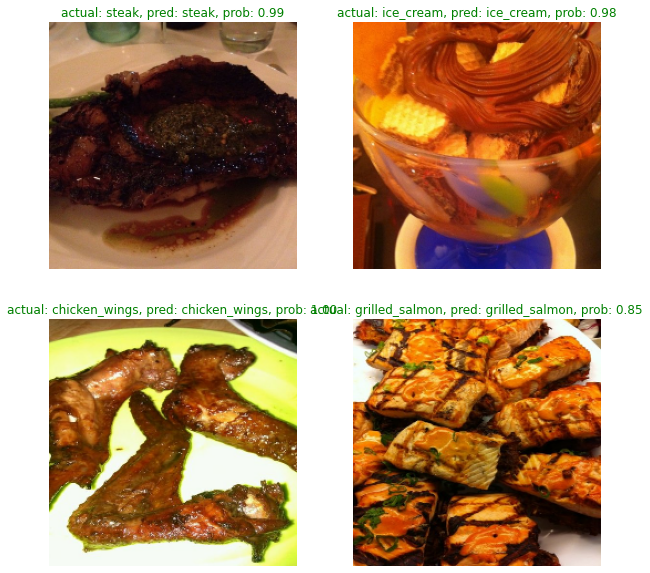

In [38]:
dataset_visualizer(train_data_10_percent, model_0)

1/1 [==============================] - 0s 92ms/step


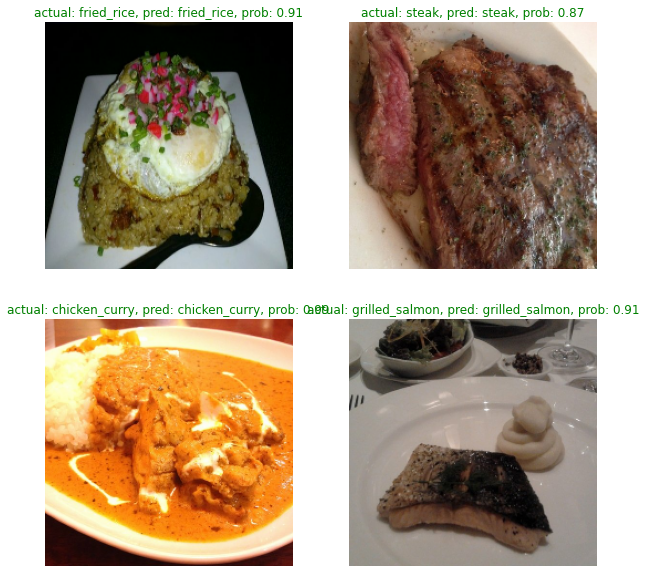

In [40]:
dataset_visualizer(test_data, model_0)